In [1]:
import os
import copy
from tqdm import tqdm
import time
import numpy as np
import torch
import torch.nn as nn
import math

from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from unet import UNet
from dice_loss import dice_coeff
####################################################
# for data splitting
####################################################
import pandas as pd
####################################################
# for data preparation
####################################################
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score
####################################################
# for plotting
####################################################
import matplotlib.pyplot as plt
from IPython.display import clear_output
############################
# Helper func
############################
from helper import * 
###################################
TRAIN_RATIO = 0.8
RS = 30448
N_CHANNELS, N_CLASSES = 1, 1 
bilinear = True
BATCH_SIZE, EPOCHS = 2, 60
IMAGE_SIZE = (256, 256)
CROP_SIZE = (224, 224)

sss = StratifiedShuffleSplit(n_splits=1, test_size=1-TRAIN_RATIO, random_state=RS)

#There are 7 types of classes in the dataset for lesions as specified:
lesion_type_dict = {
    'nv': 'Melanocytic nevi', # 0 
    'bkl': 'Benign keratosis-like lesions ',
    'mel': 'dermatofibroma',
    'vasc': 'Vascular lesions', # 3
    'bcc': 'Basal cell carcinoma', # 4 
    'akiec': 'Actinic keratoses',
    'df': 'Dermatofibroma'
}
lesion_type_dict_malignant = {
    'nv': 'ben', # 0 
    'bkl': 'ben',
    'df': 'ben',
    'vasc': 'ben', # 3
    'bcc': 'mal', # 4 
    'akiec': 'mal',
    'mel': 'mal'
}

PATH_META = 'dataset/skin_lesion/HAM10000_metadata'
#########################################
DIR = 'dataset/skin_lesion/'
## Num data #####################
'''                             #
Rosendahl : 2259                #
Vidir modern : 3363             #
vienna dias : 439               #
vidir molemax : 3954            #
'''                             # 
#################################

print()

In [2]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
CLIENTS = ['ROSENDAHL', 'VIDIR_MODERN', 'VIENNA_DIAS', 'VIDIR_MOLEMAX']
CLIENTS_2 = [cl + '_2' for cl in CLIENTS]
###################################################################
TOTAL_CLIENTS = len(CLIENTS)

DIR_DATA = DIR + 'derma/'
DIR_GT = DIR + 'GT/'

derma_ = pd.read_csv(PATH_META)
C1_rosendahl_idx = derma_['dataset'] == 'rosendahl'
C2_vidir_modern_idx = derma_['dataset'] == 'vidir_modern'
C3_vienna_dias_idx = derma_['dataset'] == 'vienna_dias'
C4_vidir_molemax_idx = derma_['dataset'] == 'vidir_molemax'

skin_dataset = dict()
skin_dataset['ROSENDAHL'] = derma_['image_id'][C1_rosendahl_idx]
skin_dataset['VIDIR_MODERN'] = derma_['image_id'][C2_vidir_modern_idx]
skin_dataset['VIENNA_DIAS'] = derma_['image_id'][C3_vienna_dias_idx]
skin_dataset['VIDIR_MOLEMAX'] = derma_['image_id'][C4_vidir_molemax_idx]

split_dataset = dict()
STATIC_WEIGHT = [0,0,0,0]
order = 0

for client in tqdm(skin_dataset):
    tmp = skin_dataset[client]
    x_, y_ = [DIR_DATA+f+'.jpg' for f in tmp], \
            [DIR_GT+f+'.png' for f in tmp]
    x_train, x_test, y_train, y_test = train_test_split(
    x_, y_, test_size=1-TRAIN_RATIO, random_state=RS)

    split_dataset[client+'_train']=Cancer(x_train, y_train, train=True,\
                                          IMAGE_SIZE=IMAGE_SIZE\
                                           , CROP_SIZE=CROP_SIZE)
    STATIC_WEIGHT[order] = len(x_train)
    order += 1
    
    split_dataset[client+'_test'] =Cancer(x_test, y_test, train=False,\
                                          IMAGE_SIZE=IMAGE_SIZE\
                                           , CROP_SIZE=CROP_SIZE)
    print(client)

100%|██████████| 4/4 [00:00<00:00, 529.20it/s]

ROSENDAHL
VIDIR_MODERN
VIENNA_DIAS
VIDIR_MOLEMAX


In [4]:
VDIAS_LEN = STATIC_WEIGHT[2]

In [5]:
STATIC_WEIGHT = [item / sum(STATIC_WEIGHT) for item in STATIC_WEIGHT]
print(STATIC_WEIGHT)
WEIGHTS = STATIC_WEIGHT
WEIGHTS_DATA = copy.deepcopy(WEIGHTS)

[0.22556484833354137, 0.33578829109973785, 0.04381475471227063, 0.3948321058544501]


In [6]:


device = torch.device('cuda:0')
LR, WD, TH = 1e-3, 1e-4, 0.9
best_avg_acc, best_epoch = 0.0, 0



In [7]:
training_clients, testing_clients = dict(), dict()
training_clients_pl = dict()

acc_train, acc_test, loss_train, loss_test = dict(), dict(), \
                                            dict(), dict()
    
nets, optimizers = dict(), dict()

nets['global'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)

nets['global_2'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)

for client in tqdm(CLIENTS):
    print(client)
    training_clients[client] = DataLoader(split_dataset[client+'_train'], batch_size=BATCH_SIZE,\
                 shuffle=True, num_workers=8)
    training_clients_pl[client] = DataLoader(split_dataset[client+'_train'], batch_size=BATCH_SIZE, \
                shuffle=True, num_workers=8)
    ###################################################################################
    testing_clients[client] = DataLoader(split_dataset[client+'_test'], batch_size=BATCH_SIZE,\
                         shuffle=False, num_workers=1)
    
    acc_train[client], acc_test[client] = [], []
    loss_train[client], loss_test[client] = [], []
        
    nets[client] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)
    nets[client+'_2'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)
    optimizers[client]= optim.Adam(nets[client].parameters(), \
                                   lr=LR,weight_decay=WD)
    optimizers[client+'_2']= optim.Adam(nets[client+'_2'].parameters(), \
                                   lr=LR,weight_decay=WD)

  0%|          | 0/4 [00:00<?, ?it/s]

ROSENDAHL


 25%|██▌       | 1/4 [00:00<00:01,  2.31it/s]

VIDIR_MODERN


 50%|█████     | 2/4 [00:00<00:00,  2.33it/s]

VIENNA_DIAS


 75%|███████▌  | 3/4 [00:01<00:00,  2.33it/s]

VIDIR_MOLEMAX


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


In [8]:
# CLIENTS_SUPERVISION = ['unlabeled', 'unlabeled', 'labeled', 'unlabeled'] # [U,U,L,U]
CLIENTS_SUPERVISION = ['bbox','bbox','labeled', 'bbox'] # [B, B, L, B]

In [9]:
LAMBDA_ = 10
BETA_ = 3
TH = 0.9

# FedMix

0.8295497282620445 0.8557077973602423
[0.3304913157932366, 0.15728698423195156, 0.4269128761785486, 0.08530882379626344]


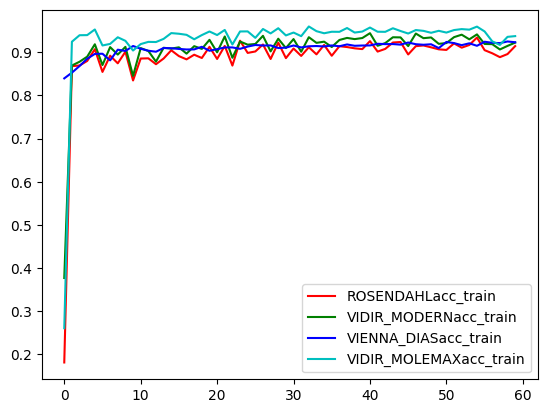

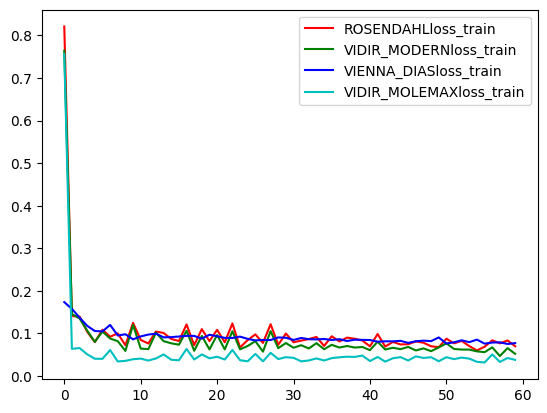

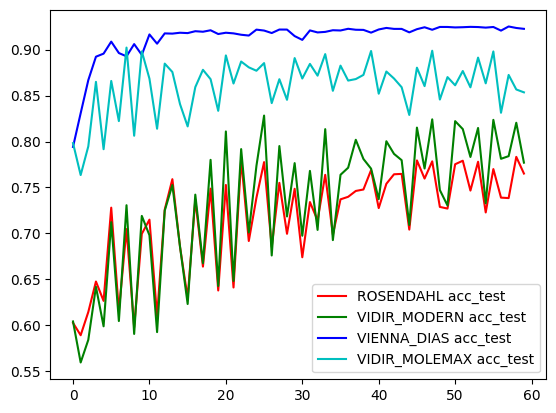

100%|██████████| 60/60 [13:43:20<00:00, 823.34s/it]


0.8557077973602423 47


100%|██████████| 4/4 [00:00<00:00, 11538.66it/s]

ROSENDAHL
shared epoch specific
0.778419359859112
max client-specific
0.7832945010303396
VIDIR_MODERN
shared epoch specific
0.8240966704019099
max client-specific
0.8282175285172392
VIENNA_DIAS
shared epoch specific
0.921563521027565
max client-specific
0.9251287037676031
VIDIR_MOLEMAX
shared epoch specific
0.8987516381523826
max client-specific
0.9021612291384224


In [10]:
best_avg_acc, best_epoch_avg = 0,0
index = []

for client in CLIENTS:
    acc_train[client], acc_test[client] = [], []
    loss_train[client], loss_test[client] = [], []

WEIGHTS = [0.0, 0.0, 0.0, 0.0]
DATA_NUM = [0,0, VDIAS_LEN, 0]
score = [0,0,0,0]

for epoch in tqdm(range(EPOCHS)):        
    index.append(epoch)
    DATA_NUM = [0,0, VDIAS_LEN, 0]
    #################### copy fed model ###################
    copy_fed(CLIENTS, nets, fed_name='global')
    copy_fed(CLIENTS_2, nets, fed_name='global_2')
    
    ######################################################
    # generate and refine pseudo labels ##################
    ######################################################
    for order, client in tqdm(enumerate(CLIENTS)):
        bbox, image = False, False
        if CLIENTS_SUPERVISION[order] == 'labeled':
            continue
        elif CLIENTS_SUPERVISION[order] == 'bbox':
            bbox = True
        elif CLIENTS_SUPERVISION[order] == 'image':
            image= True
        ##################################################
        # save pl ########################################
        ##################################################
        im_store, pl1_store, pl2_store = [], [], []
        
        tmp_ = select_pl_singleclass(nets['global'], nets['global_2'], device,\
                      training_clients_pl[client], im_store, pl1_store, \
                      pl2_store, TH=TH, bbox=bbox, image=image)
        
        if len(im_store) >= 1:
            tmp_dataset = cancer_v2(im_store, pl1_store, pl2_store)
            training_clients[client] = DataLoader(tmp_dataset, batch_size=16,\
                             shuffle=True, num_workers=8)

        DATA_NUM[order] = tmp_
    
    torch.cuda.empty_cache()
    #######################################################
    #### Conduct training #################################
    #######################################################
    for order, (client, supervision_t) in tqdm(enumerate(zip(CLIENTS, CLIENTS_SUPERVISION))):
        if supervision_t == 'labeled':
            # train network 1 #
            train_model(training_clients[client], nets[client], optimizers[client], device, \
                       acc=acc_train[client], loss=loss_train[client], \
                        supervision_type=supervision_t)
            
            # train network 2 # 
            train_model(training_clients[client], nets[client+'_2'], optimizers[client+'_2'], device, \
                       acc=None, loss=None, \
                        supervision_type=supervision_t)
            
        else: # train using pseudo label # 
            # train network 1 #
            train_model(training_clients[client], nets[client], optimizers[client], device, \
                       acc=acc_train[client], loss=loss_train[client], \
                        supervision_type=supervision_t, FedMix_network=1)
            
            # train network 2 # 
            train_model(training_clients[client], nets[client+'_2'], optimizers[client+'_2'], device, \
                       acc=None, loss=None, \
                        supervision_type=supervision_t, FedMix_network=2)
        
        
        # save loss for future reweighting # 
        score[order] = loss_train[client][-1] ** BETA_
    ###################################
    ####### dynamic weighting #########
    ###################################
    denominator = sum(score)
    score = [s/denominator for s in score]
    
    denominator = sum(DATA_NUM)
    WEIGHTS_CL = [s/denominator for s in DATA_NUM]
    for order, _ in tqdm(enumerate(WEIGHTS)):
        WEIGHTS[order] = WEIGHTS_CL[order] + LAMBDA_ * score[order]
        
    ### normalize #####################
    denominator = sum(WEIGHTS)
    WEIGHTS = [w/denominator for w in WEIGHTS]

    ###################################
    ####### aggregation ###############
    ###################################
    aggr_fed(CLIENTS, WEIGHTS, nets, fed_name='global')
    aggr_fed(CLIENTS_2, WEIGHTS, nets, fed_name='global_2')
    
    
    avg_acc = 0.0
    for client in tqdm(CLIENTS):
        test(epoch, testing_clients[client], nets['global'], device, acc_test[client],\
             loss_test[client])
        avg_acc += acc_test[client][-1]
        
    avg_acc = avg_acc / TOTAL_CLIENTS
    ############################################################
    ########################################################
    if avg_acc > best_avg_acc:
        best_avg_acc = avg_acc
        best_epoch = epoch
    
    ################################
    # plot #########################
    ################################
    clear_output(wait=True)
    print(avg_acc, best_avg_acc)
    print(WEIGHTS)
    plot_graphs(0, CLIENTS, index, acc_train, 'acc_train')
    plot_graphs(1, CLIENTS, index, loss_train, 'loss_train')
    plot_graphs(2, CLIENTS, index, acc_test, ' acc_test')

print(best_avg_acc, best_epoch)
for client in tqdm(CLIENTS):
    print(client)
    tmp = best_epoch
    best_epoch = best_epoch 
    print("shared epoch specific")
    print(acc_test[client][best_epoch])
    print("max client-specific")
    print(np.max(acc_test[client]))
    best_epoch = tmp

In [11]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 146137       |        cudaMalloc retries: 146332    |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   2323 MiB |   6467 MiB |    954 TiB |    954 TiB |
|       from large pool |   2264 MiB |   6409 MiB |    948 TiB |    948 TiB |
|       from small pool |     59 MiB |     68 MiB |      6 TiB |      6 TiB |
|---------------------------------------------------------------------------|
| Active memory         |   2323 MiB |   6467 MiB |    954 TiB |    954 TiB |
|       from large pool |   2264 MiB |   6409 MiB |    948 TiB |